In [1]:
repo_root=!git rev-parse --show-toplevel
import os
os.chdir(repo_root[0])

In [2]:
!rm -rf old-liab
!git clone https://github.com/kavaryan/liab/ old-liab

Cloning into 'old-liab'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 270 (delta 135), reused 202 (delta 73), pack-reused 0 (from 0)
Receiving objects: 100% (270/270), 1.54 MiB | 6.90 MiB/s, done.
Resolving deltas: 100% (135/135), done.


Benchmarking SCM performance with 100 random SCMs...
Each SCM tested with 100 iterations
SCM size: 10 variables, function type: linear
Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100

Results from 100 successful benchmarks:
Liab SCM time: 0.438501 ± 0.138902 seconds
Core SCM time: 0.001389 ± 0.000206 seconds
Average speedup: 323.29x (median: 334.59x)


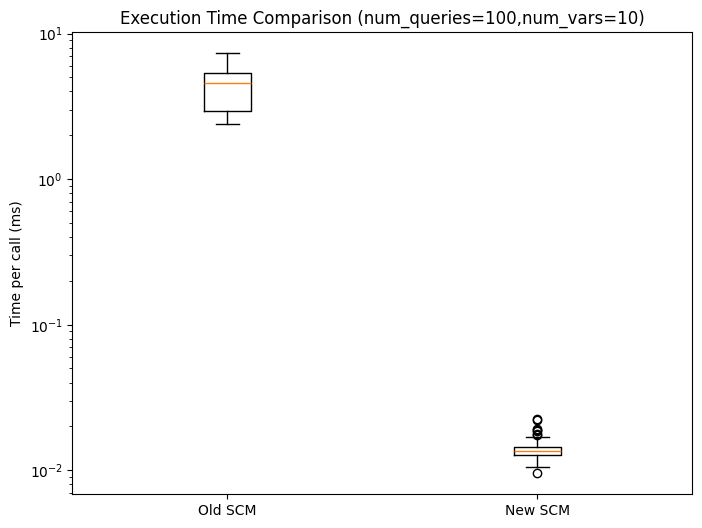

Benchmark completed successfully!


In [3]:
"""Benchmark script to compare performance between two SCM implementations."""

import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add paths to import both implementations
sys.path.append('old-liab/src')

# Import both SCM implementations
from liab.scm import ComponentOrEquation, System
from core.scm import Component, SCMSystem, BoundedFloatInterval
from core.random_system import get_rand_system

def create_liab_scm_from_core(core_scm):
    """Create an SCM using the tmp/liab implementation from a core SCM."""
    components = []
    
    for comp in core_scm.components.values():
        # Convert core Component to liab ComponentOrEquation
        # Ensure expression is a string
        expression_str = str(comp.expression) if comp.expression is not None else ""
        liab_comp = ComponentOrEquation(comp.input_vars, comp.output, expression_str)
        components.append(liab_comp)
    
    system = System(components)
    scm = system.induced_scm()
    return scm

def create_random_scm_pair(N=5, func_type='linear', seed=None):
    """Create a pair of equivalent random SCMs using both implementations."""
    rnd = np.random.RandomState(seed) if seed is not None else None
    
    # Create random core SCM
    core_scm = get_rand_system(N, func_type, rnd=rnd, seed=seed)
    
    # Create equivalent liab SCM
    liab_scm = create_liab_scm_from_core(core_scm)
    
    return liab_scm, core_scm

def benchmark_single_scm(liab_scm, core_scm, context, num_iterations=1000):
    """Benchmark a single SCM pair."""
    # Verify both produce same results
    liab_state, _ = liab_scm.get_state(context)
    core_state = core_scm.get_state(context)
    
    # Benchmark liab implementation
    start_time = time.perf_counter()
    for _ in range(num_iterations):
        liab_scm.get_state(context)
    liab_time = time.perf_counter() - start_time
    
    # Benchmark core implementation  
    start_time = time.perf_counter()
    for _ in range(num_iterations):
        core_scm.get_state(context)
    core_time = time.perf_counter() - start_time
    
    return liab_time, core_time

def benchmark_scm_performance(num_repeats=100, num_iterations=100, N=10, func_type='linear'):
    """Benchmark both SCM implementations with multiple random SCMs."""
    print(f"Benchmarking SCM performance with {num_repeats} random SCMs...")
    print(f"Each SCM tested with {num_iterations} iterations")
    print(f"SCM size: {N} variables, function type: {func_type}")
    
    liab_times = []
    core_times = []
    speedups = []
    
    for i in range(num_repeats):
        if (i + 1) % 10 == 0:
            print(f"Progress: {i + 1}/{num_repeats}")
        
        # Create random SCM pair
        try:
            liab_scm, core_scm = create_random_scm_pair(N=N, func_type=func_type, seed=i)
            
            # Generate random context for exogenous variables
            context = core_scm.get_random_context()
            
            # Benchmark this SCM pair
            liab_time, core_time = benchmark_single_scm(liab_scm, core_scm, context, num_iterations)
            
            if liab_time is not None and core_time is not None:
                liab_times.append(liab_time)
                core_times.append(core_time)
                speedups.append(liab_time / core_time)
        except Exception as e:
            print(f"Error with SCM {i}: {e}")
            continue
    
    if not liab_times:
        print("No successful benchmarks!")
        return None, None, None
    
    # Convert to numpy arrays for easier manipulation
    liab_times = np.array(liab_times)
    core_times = np.array(core_times)
    speedups = np.array(speedups)
    
    # Print summary statistics
    print(f"\nResults from {len(liab_times)} successful benchmarks:")
    print(f"Liab SCM time: {np.mean(liab_times):.6f} ± {np.std(liab_times):.6f} seconds")
    print(f"Core SCM time: {np.mean(core_times):.6f} ± {np.std(core_times):.6f} seconds")
    print(f"Average speedup: {np.mean(speedups):.2f}x (median: {np.median(speedups):.2f}x)")
    
    # Create boxplot
    plt.figure(figsize=(8, 6))
    
    # Convert times to milliseconds per call for better readability
    liab_times_ms = (liab_times / num_iterations) * 1000
    core_times_ms = (core_times / num_iterations) * 1000
    
    plt.boxplot([liab_times_ms, core_times_ms], tick_labels=['Old SCM', 'New SCM'])
    plt.ylabel('Time per call (ms)')
    plt.title(f'Execution Time Comparison (num_queries={num_iterations},num_vars={N})')
    plt.yscale('log')
    plt.savefig('scm_benchmark_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return liab_times, core_times, speedups

if __name__ == "__main__":
    # Run benchmark with 100 random SCMs
    result = benchmark_scm_performance(
        num_repeats=100, 
        num_iterations=100, 
        N=10, 
        func_type='linear'
    )
    
    if result is not None:
        liab_times, core_times, speedups = result
        print("Benchmark completed successfully!")
    else:
        print("Benchmark failed - no successful runs.")
